In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import pickle
from sklearn.model_selection import train_test_split
import time


In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [4]:
from google.colab import drive
drive.mount('/content/drive'  )


Mounted at /content/drive


In [5]:
# Load the dataset
training_file = r"/content/drive/MyDrive/traffic_sign_dataset/train.p"
testing_file = r"/content/drive/MyDrive/traffic_sign_dataset/test.p"

def load_traffic_sign_data(training_file, testing_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    return train, test

train, test = load_traffic_sign_data(training_file, testing_file)
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']




In [6]:
def preprocess_features(X):
    X_yuv = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, 0] for img in X])
    X_yuv = np.array([cv2.equalizeHist(np.uint8(img)) for img in X_yuv])
    X_yuv = np.expand_dims(X_yuv, axis=-1)  # Keep single-channel shape
    X_yuv = X_yuv.astype(np.float32)
    X_yuv -= np.mean(X_yuv, axis=0)
    X_yuv /= (np.std(X_yuv, axis=0) + np.finfo('float32').eps)
    return X_yuv

X_train_norm = preprocess_features(X_train)
X_test_norm = preprocess_features(X_test)

In [7]:
test_size = 0.2
X_train_norm, X_val_norm, y_train, y_val = train_test_split(
    X_train_norm, y_train, test_size=test_size, random_state=42
)


In [8]:
# Convert grayscale images to 3-channel format for MobileNetV2 (expected input: (224, 224, 3))
X_train_norm = np.repeat(X_train_norm, 3, axis=-1)
X_val_norm = np.repeat(X_val_norm, 3, axis=-1)
X_test_norm = np.repeat(X_test_norm, 3, axis=-1)

# Resize Images in Batches to Avoid OOM Errors
def resize_images(images, target_size=(32, 32)):
    resized_images = [tf.image.resize(img, target_size).numpy() for img in images]
    return np.array(resized_images, dtype=np.float32)

X_train_resized = resize_images(X_train_norm)
X_val_resized = resize_images(X_val_norm)
X_test_resized = resize_images(X_test_norm)

In [9]:
#  Optimized Data Augmentation
image_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.1,
    height_shift_range=0.1
)

# MobileNetV2 Model (Fine-Tuning Enabled)
def create_mobilenetv2_model(input_shape, n_classes):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape,alpha=0.5)
    base_model.trainable = True  # Unfreeze MobileNetV2 layers for fine-tuning

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(n_classes, activation='softmax', dtype='float32')(x)  # Ensure compatibility with mixed precision

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

input_shape = (32, 32, 3)
n_classes = 43
model = create_mobilenetv2_model(input_shape, n_classes)

# Compile Model with Lower Learning Rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

<ipython-input-9-a0fdb73512c1>:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape,alpha=0.5)


3201480/3201480 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 32, 32, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 16)     │            432 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 16)     │             64 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 16)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 16)     │            144 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 16)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 8)      │            128 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 8)      │             32 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 48)     │            384 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 48)     │            192 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 48)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 48)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 48)       │            432 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)    

 Total params: 1,504,475 (5.74 MB)

 Trainable params: 1,485,931 (5.67 MB)

 Non-trainable params: 18,544 (72.44 KB)

In [11]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training Parameters
BATCHSIZE = 32  # Reduced batch size to avoid memory issues
EPOCHS = 70  # Increased epochs

# Start Timer
start_time = time.time()

# Train Model
history = model.fit(
    image_datagen.flow(X_train_resized, y_train, batch_size=BATCHSIZE),
    validation_data=(X_val_resized, y_val),
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


870/870 ━━━━━━━━━━━━━━━━━━━━ 131s 81ms/step - accuracy: 0.0532 - loss: 4.1279 - val_accuracy: 0.1024 - val_loss: 3.6280
Epoch 2/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.1549 - loss: 3.2117 - val_accuracy: 0.1523 - val_loss: 3.3689
Epoch 3/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.2597 - loss: 2.6736 - val_accuracy: 0.2674 - val_loss: 2.8406
Epoch 4/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.3399 - loss: 2.2941 - val_accuracy: 0.3941 - val_loss: 2.1412
Epoch 5/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.4032 - loss: 2.0200 - val_accuracy: 0.4717 - val_loss: 1.7942
Epoch 6/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.4652 - loss: 1.7905 - val_accuracy: 0.5629 - val_loss: 1.4538
Epoch 7/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.4966 - loss: 1.6470 - val_accuracy: 0.5999 - val_loss: 1.2800
Epoch 8/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.5493 - loss: 1.4785 - val_accura

In [12]:
# End Timer
end_time = time.time()

# Compute Total Training Time
hours = int((end_time - start_time) // 3600)
minutes = int(((end_time - start_time) % 3600) // 60)
seconds = int((end_time - start_time) % 60)
print(f"\nTraining Completed in: {hours}h {minutes}m {seconds}s")

# Save Model Weights
model.save_weights('mobilenetv2_traffic_sign.weights.h5')
print("Model training complete. Weights saved successfully.")



Training Completed in: 0h 33m 52s
Model training complete. Weights saved successfully.


In [15]:
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8742 - loss: 0.4692
Test Accuracy: 0.8719, Test Loss: 0.4736


395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step


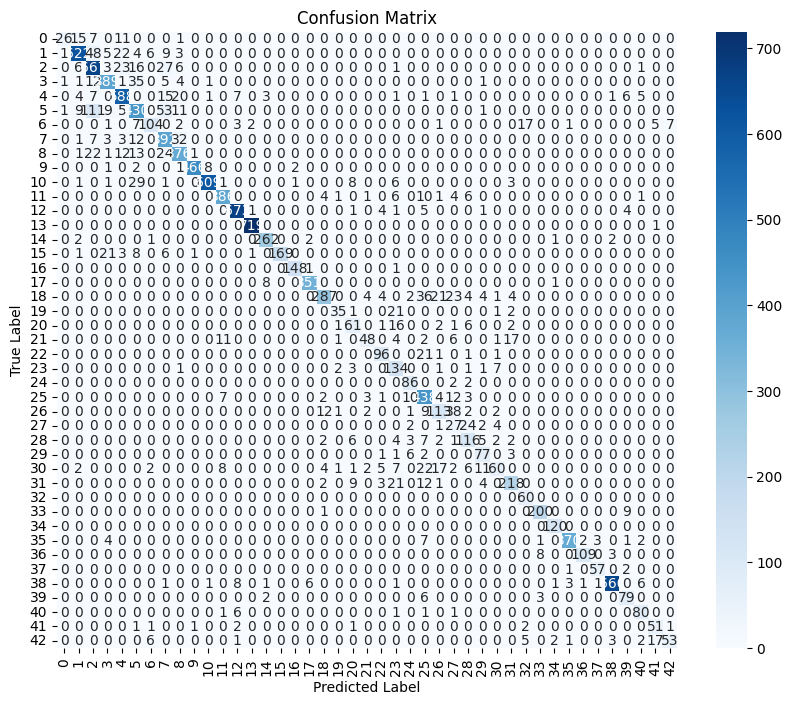

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.43      0.58        60
           1       0.94      0.86      0.90       720
           2       0.76      0.89      0.82       750
           3       0.89      0.86      0.88       450
           4       0.88      0.89      0.89       660
           5       0.77      0.68      0.72       630
           6       0.87      0.69      0.77       150
           7       0.74      0.87      0.80       450
           8       0.82      0.84      0.83       450
           9       0.99      0.97      0.98       480
          10       0.98      0.92      0.95       660
          11       0.93      0.92      0.93       420
          12       0.96      0.98      0.97       690
          13       0.99      1.00      1.00       720
          14       0.95      0.97      0.96       270
          15       1.00      0.80      0.89       210
          16       0.98      0.99      0.98       150
    

In [13]:
# Confusion Matrix & Classification Report
y_pred_probs = model.predict(X_test_resized)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(20, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

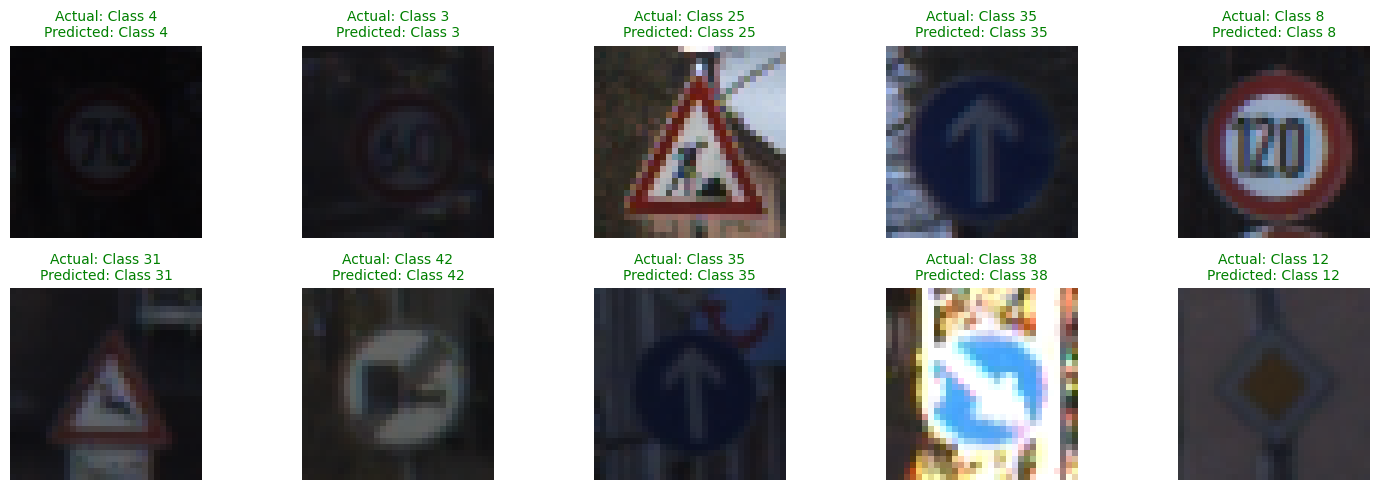

In [14]:
# Image Association with Predictions
class_labels = {i: f"Class {i}" for i in range(n_classes)}

# Number of images to display
num_images = 10
indices = np.random.choice(len(X_test_resized), num_images, replace=False)

# Plot images with actual & predicted labels
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    actual_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_pred[idx]]

    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10,
              color='green' if y_test[idx] == y_pred[idx] else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

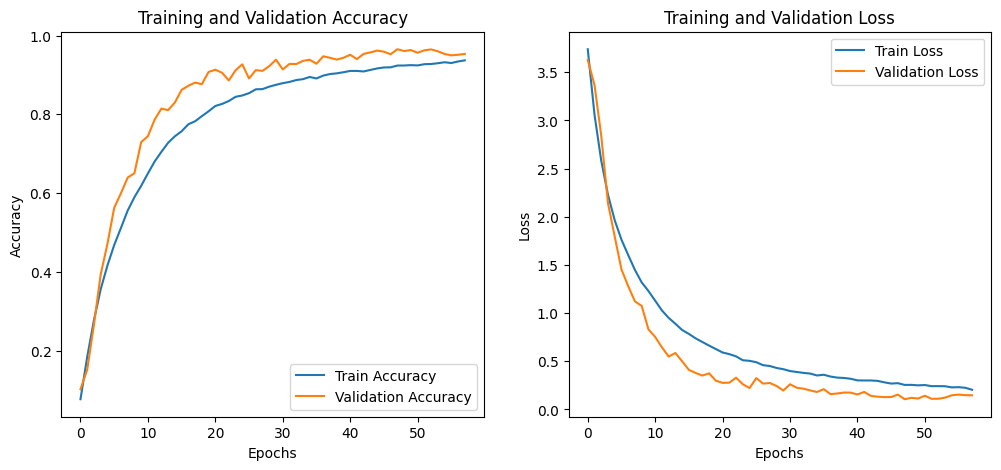

In [16]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

  # Generate accuracy & loss graph
plot_accuracy_loss(history)

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


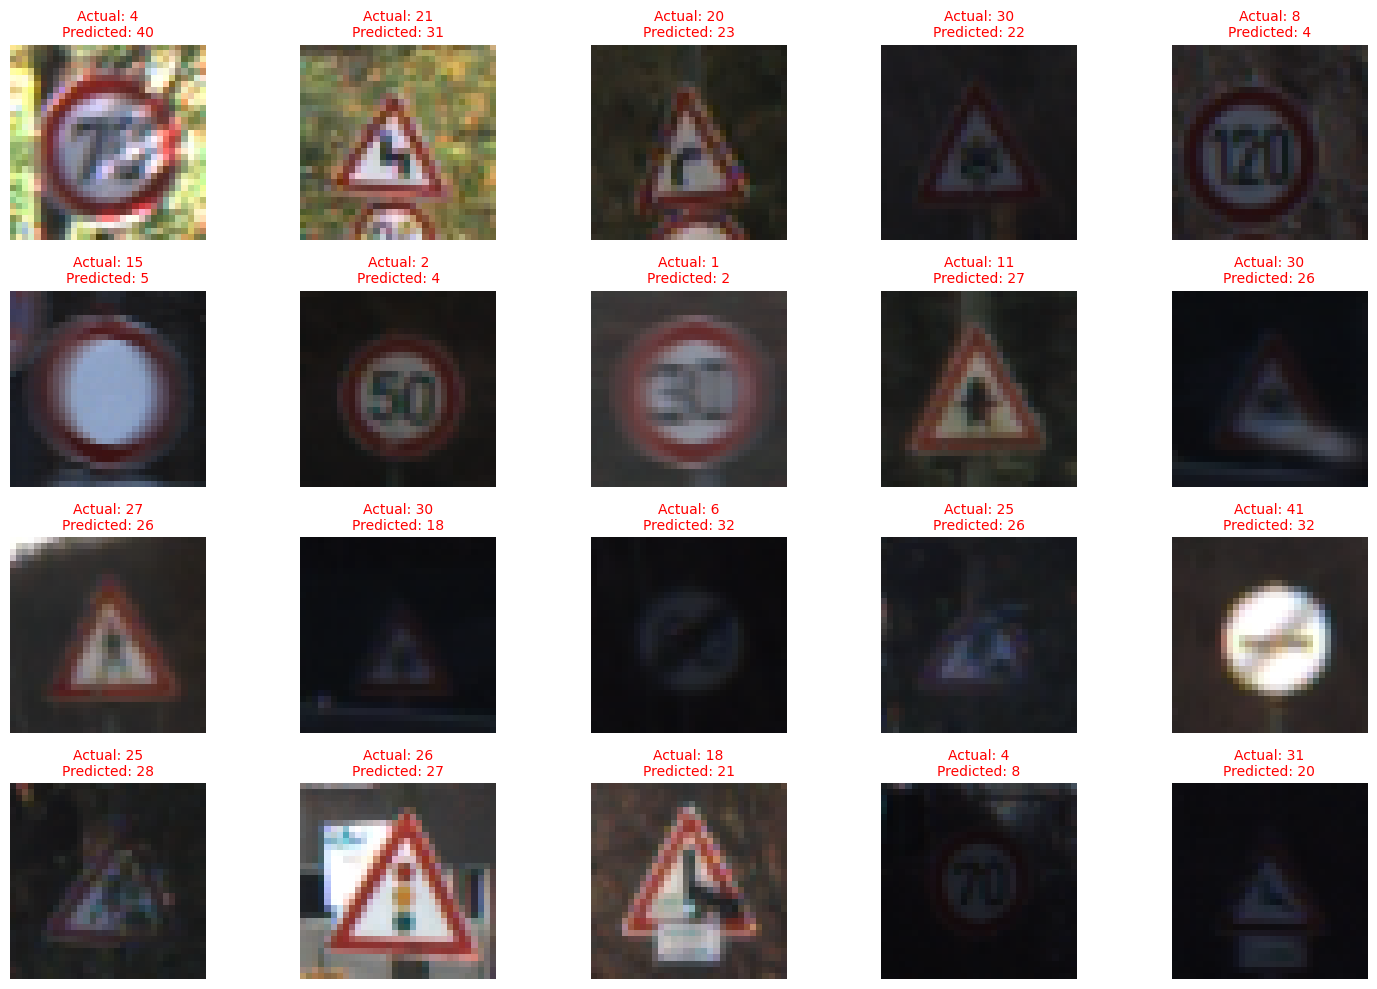

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
y_pred_probs = model.predict(X_test_norm)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels

# Find misclassified indices
misclassified_idx = np.where(y_pred != y_test)[0]

# Number of misclassified images to display
num_images = min(20, len(misclassified_idx))  # Show up to 20 misclassified images

# Plot misclassified images with actual & predicted labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx[:num_images]):
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns
    plt.imshow(X_test[idx].squeeze(), cmap='gray')  # Display image
    actual_label = y_test[idx]
    predicted_label = y_pred[idx]

    # Title showing Actual vs Predicted
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10, color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

